# 学习笔记2-数据扩增

在Baseline代码跑通后， 需要考虑提高模型效率，减小损失的方法。  
对于语义分割模型，减小损失函数的首要方法是进行数据扩增。因为，进行深度学习的图片数量一般不够大，需要通过种种手段，增加训练的数据量，才能有效改进模型性能。
本笔记根据天池提供的”数据扩增、损失评价函数“视频，总结了数据扩增方法。并使用常用的几种方法，进行代码改造。同时，针对原有损失函数的缺点，进行优化。根据优化后的代码，跑出的结果有明显的改善。  


## 1、数据扩增方法

数据扩增是一种有效的正则化方法，可以缓解模型过拟合，可以迫使网络学习到更鲁棒、更多样的特征，给模型带来更强的泛化能力。
常用数据扩增技术分类：
1) 基于图像处理的数据扩增
2）基于深度学习的数据扩增


本项目中主要使用图像处理的数据扩增，包括以下方面：  
1）几何变换  
a、旋转  
b、缩放  
c、翻转  
d、裁剪  
e、平移  
f、仿射变换  
作用：几何变换可以有效地对抗数据中存在的位置偏差、视角偏差、尺寸偏差，而且易于实现，非常常用。  

2）灰度和彩色空间变换  
a、亮度调整  
b、对比度、饱和度调整  
c、颜色空间转换  
d、色彩调整  
e、gamma变换  
作用：对抗数据中存在的光照、色彩、亮度、对比度偏差。  

3）添加噪声和滤波  
a、添加高斯噪声、椒盐噪声等  
b、滤波：模糊、锐化、雾化等
作用：应对噪声干扰、恶劣环境、成像异常等特殊情况，帮助CNN学习更广泛的特征。  

4）图像混合  

5）随机擦除  

本程序中使用Albumentations库函数进行数据增强，只选择了常用的几个函数，见程序。

## 2、损失函数优化 

    原baseline程序使用的损失方法是bce+Dice。由于bce的缺点是，当前景像素的数量远远小于背景像素的数量时，可能会使模型严重偏向背景，导致效果不佳。这个问题在我们的样本中是存在的，所以，考虑一个新的损失函数。  
    Focal loss能够有效的解决正负样本、难易样本比例失调的问题。将损失函数改成0.8*focal+0.2*Dice。

## 3、优化代码

In [13]:
#!pip install opencv-python --user
#!pip install --upgrade pip
#!pip install tqdm --user
#!pip install albumentations --user
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import cv2, gc
from tqdm import tqdm_notebook
#from tqdm_notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#from tqdm.notebook import tqdm

import albumentations as A

#import rasterio
#from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

### 增加数据扩增方法：随机裁剪（A.RandomCrop）和颜色对比度变换（ColorJitter）

In [ ]:
EPOCHES = 20
BATCH_SIZE = 32
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.ColorJitter(brightness=0.2, contrast=0.2,p=0.5)
])


In [ ]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [ ]:
train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: 'train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

In [ ]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

In [ ]:
image, mask = dataset[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

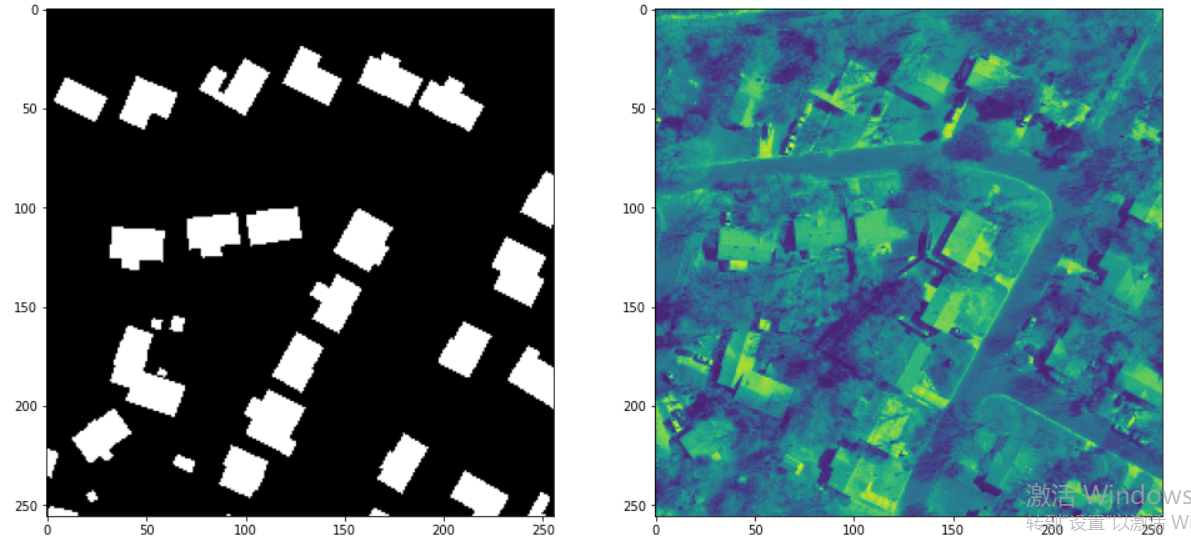

In [ ]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 7 == 0:
        valid_idx.append(i)
#     else:
    elif i % 7 == 1:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet101(True)
    
#     pth = torch.load("../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

### 基于pytorch库中的二分类交叉熵实现Focal loss函数。

In [ ]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc

class FocalLoss(nn.Module):
def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.logits = logits
    self.reduce = reduce

def forward(self, inputs, targets):
    if self.logits:
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
    else:
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
    pt = torch.exp(-BCE_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

    if self.reduce:
        return torch.mean(F_loss)
    else:
        return F_loss
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()
focal_fn = FocalLoss()
def loss_fn(y_pred, y_true):
    focal = focal_fn(y_pred.sigmoid(), y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*focal+ 0.2*dice

In [ ]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 5
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')

下图是训练后的结果：
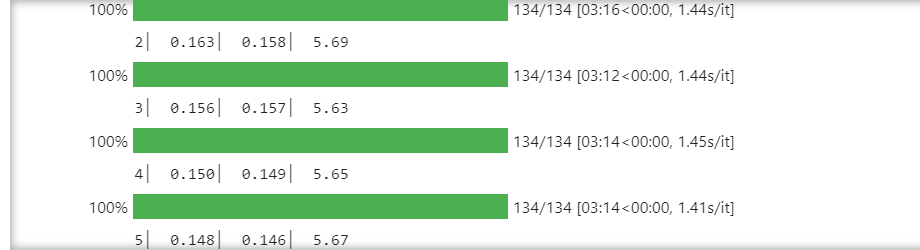

对比Baseline中的多轮训练的损失函数，可以看到损失值有明显的减小。  
Baseline训练结果：  

        Train | Valid  
Epoch |  Loss |  Loss | Time, m  

Error displaying widget: model not found  
     1│  0.407│  0.326│  8.61  
Error displaying widget: model not found  
     2│  0.281│  0.257│  8.48  
Error displaying widget: model not found  
     3│  0.243│  0.230│  8.45  
Error displaying widget: model not found  
     4│  0.227│  0.223│  8.40  
Error displaying widget: model not found  
     5│  0.217│  0.225│  8.28  

In [ ]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

In [ ]:
test_mask = pd.read_csv('数据集/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '数据集/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [ ]:
subm = pd.DataFrame(subm)
subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('数据集/test_a/' + subm[0].iloc[0]));


下图是模型预测结果， 可以看到Mask与原图非常接近， 效果远好于Baseline。

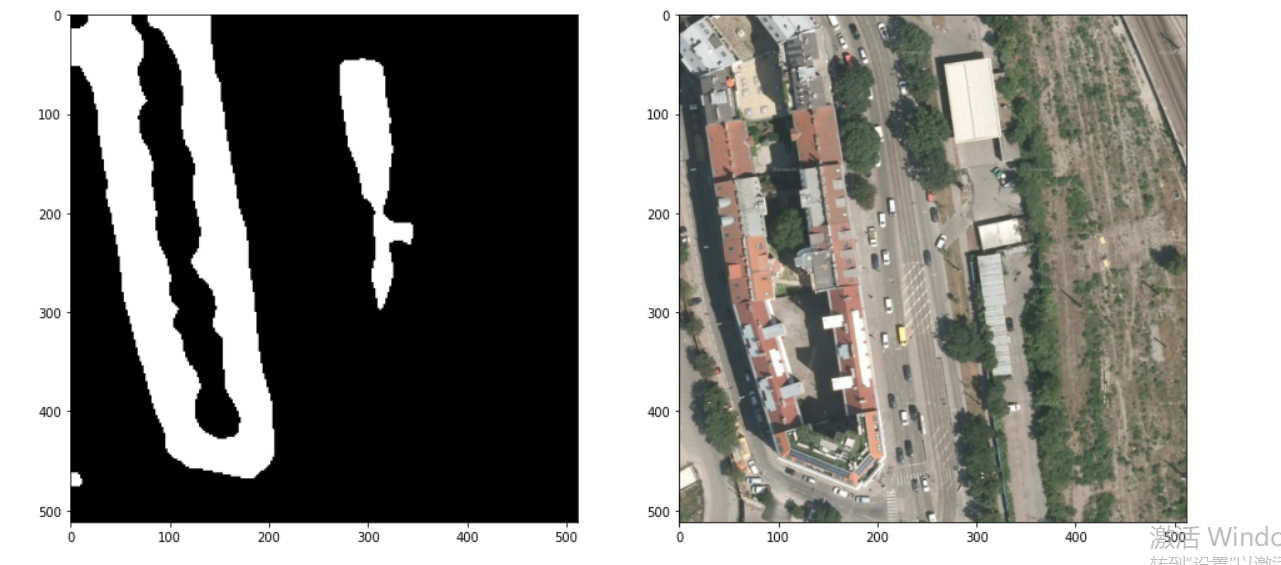